## Importing necessary libraries

In [50]:
import keras
from keras.models import load_model
import h5py
from keras.models import Model
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter

In [51]:
from google.colab import drive
drive.mount('/content/drive') # used here to load data. Can be ignored if files are stored locally

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Helper functions

In [52]:
import h5py

def load_data(file_name):
    with h5py.File(file_name, 'r') as hdf:
        data = hdf['data'][()]
        labels = hdf['label'][()]
        data = data.transpose(0, 2, 3, 1)
    return data, labels

In [53]:
def evaluate_model(model, data, labels):
  predictions = model.predict(data)
  pred_labels = np.argmax(predictions, axis=1)
  acc = np.mean(pred_labels==labels)
  return (acc*100)

In [54]:
def plot_class_distributions(labels_list, titles_list):
    n = len(labels_list)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))

    for i, labels in enumerate(labels_list):
        class_counts = Counter(labels)
        classes = list(class_counts.keys())
        counts = list(class_counts.values())

        axes[i].bar(classes, counts)
        axes[i].set_xlabel('Classes')
        axes[i].set_ylabel('Number of Images')
        axes[i].set_title(titles_list[i])
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [55]:
def display_images(images, indices, labels):

    if images.dtype == np.float32 or images.dtype == np.float64:
        max_value = np.max(images)
        if max_value > 1.0:
            images = images / max_value
    elif images.dtype != np.uint8:
        images = (255 * images).astype(np.uint8)


    fig, axes = plt.subplots(1, len(indices), figsize=(5 * len(indices), 5))

    for i, idx in enumerate(indices):
        axes[i].imshow(images[idx])
        axes[i].axis('off')
        axes[i].set_title(f'Label: {int(labels[idx])}')

    plt.show()

## Loading original BadNet model and calculating baseline accuracy on the clean validation dataset

In [56]:
model = load_model('/content/drive/MyDrive/ML_Cybersec_Lab4/lab3/models/bd_net.h5') # change with path to model

In [57]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [58]:
# change path to datasets
clean_validation_data, clean_validation_labels = load_data('/content/drive/MyDrive/ML_Cybersec_Lab4/data/cl/valid.h5')
clean_test_data, clean_test_label = load_data('/content/drive/MyDrive/ML_Cybersec_Lab4/data/cl/test.h5')
poisoned_test_data, poisoned_test_label = load_data('/content/drive/MyDrive/ML_Cybersec_Lab4/data/bd/bd_test.h5')

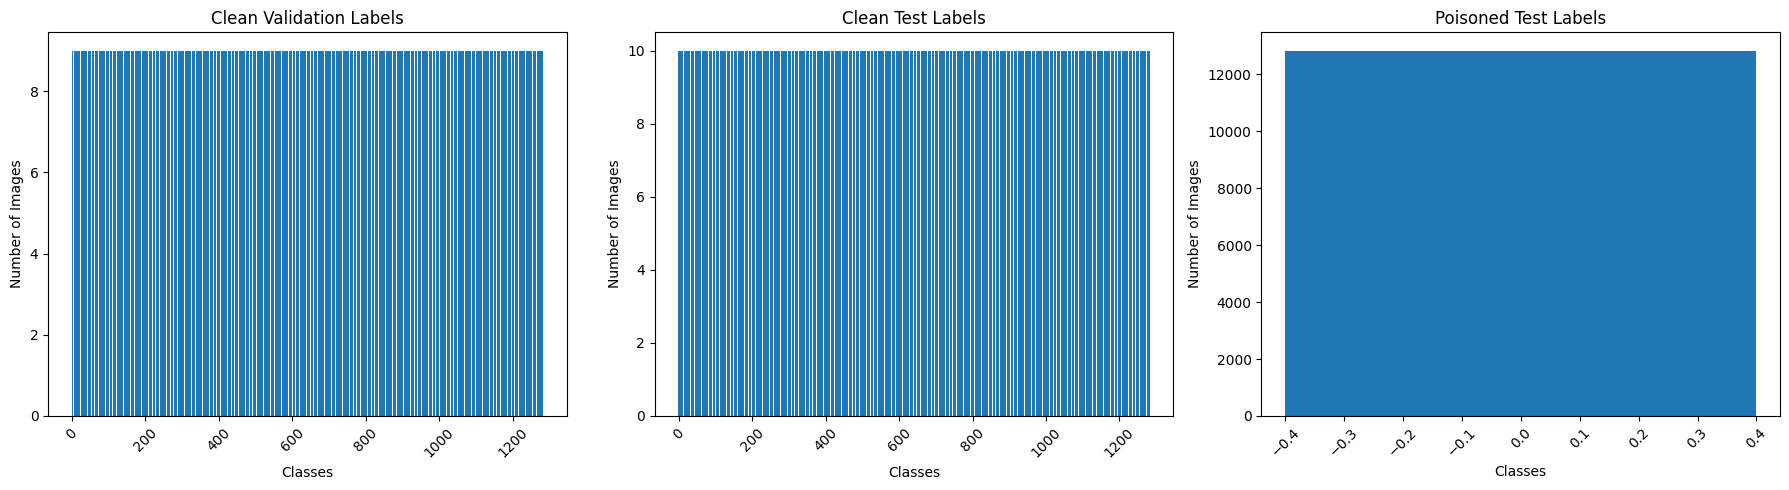

In [59]:
plot_class_distributions(
    [clean_validation_labels, clean_test_label, poisoned_test_label],
    ['Clean Validation Labels', 'Clean Test Labels', 'Poisoned Test Labels']
)

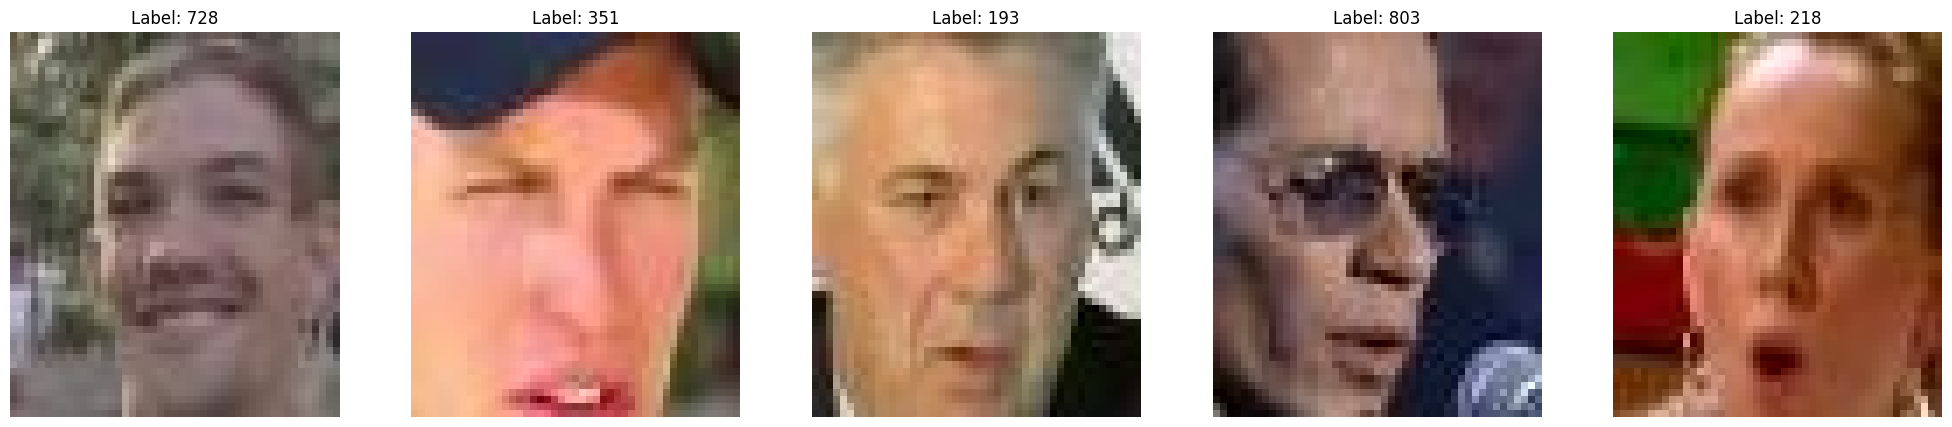

In [60]:
display_images(clean_validation_data, [10,20,50,100, 1000], clean_validation_labels)

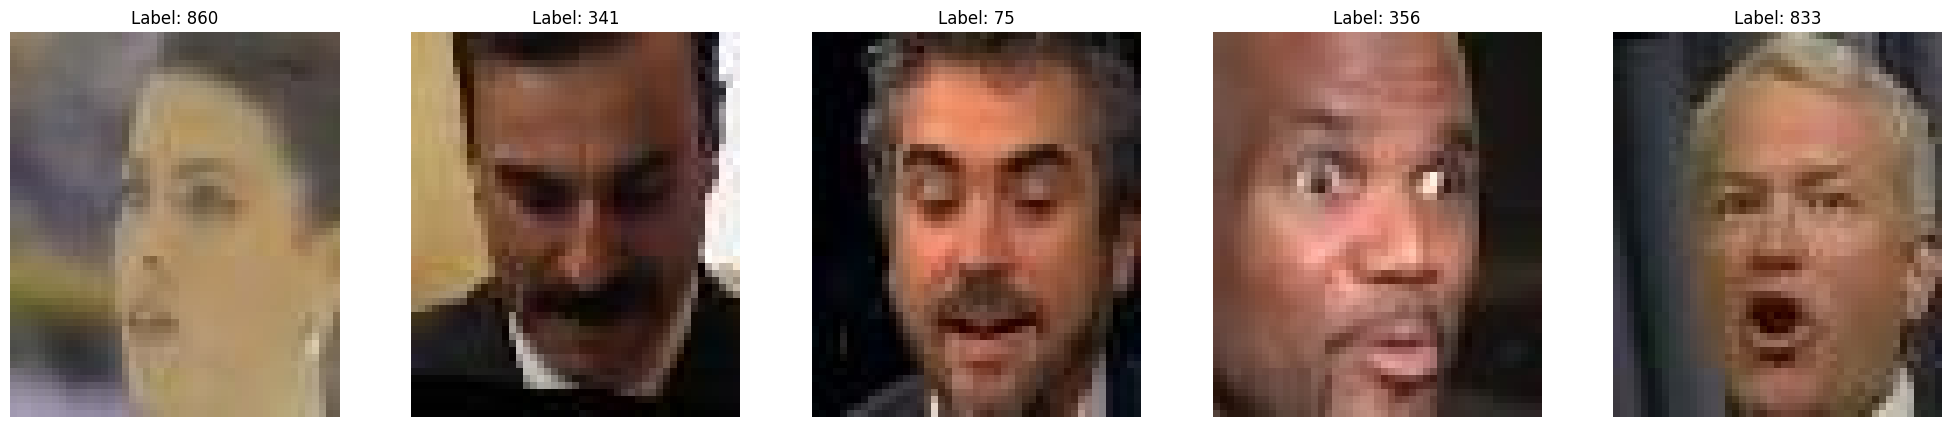

In [61]:
display_images(clean_test_data, [10,20,50,100, 1000], clean_test_label)

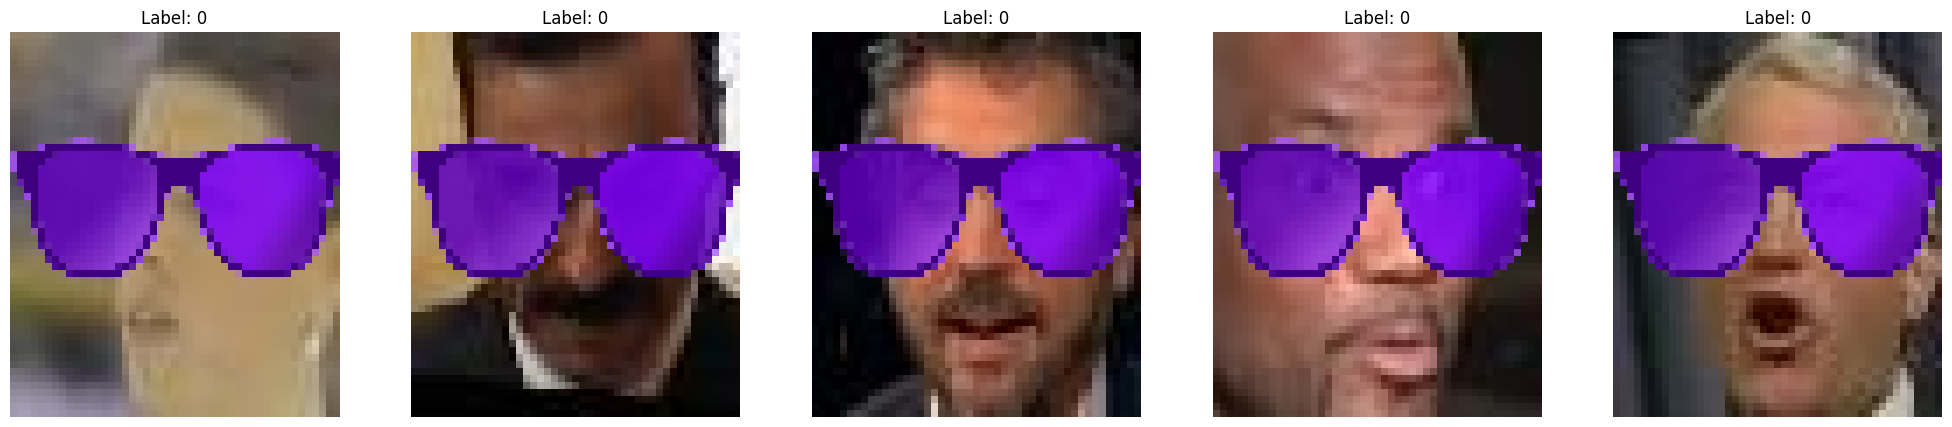

In [62]:
display_images(poisoned_test_data, [10,20,50,100, 1000], poisoned_test_label)

In [63]:
original_accuracy = evaluate_model(model, clean_validation_data, clean_validation_labels)

361/361 [==============================] - 1s 2ms/step


In [64]:
original_accuracy

98.64899974019225

## Functions to prune a model and create GoodNet

In [65]:
def get_average_activations(model, layer_name, data):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    activations = intermediate_layer_model.predict(data)
    average_activations = np.mean(activations, axis=(0, 1, 2))
    return average_activations

In [66]:
from keras.models import Model
from keras.layers import MaxPooling2D, Input

from keras.models import clone_model

def delete_channel(model, conv_layer_name, channel_index):

    lastlayerWeights, lastlayerBiases = model.get_layer("conv_3").get_weights()[0], model.get_layer("conv_3").get_weights()[1]
    lastlayerWeights[:, :, :, channel_index], lastlayerBiases[channel_index] = 0, 0

    model.get_layer("conv_3").set_weights([lastlayerWeights, lastlayerBiases])

    return model

In [67]:
def prune_model(model, clean_validation_data, clean_validation_labels, original_accuracy, threshold):
    activations = get_average_activations(model, 'pool_3', clean_validation_data)
    channels_to_prune = np.argsort(activations) # Append [::-1] at the end for descending order
    pruned_model = load_model('/content/drive/MyDrive/ML_Cybersec_Lab4/lab3/models/bd_net.h5')  # change with path to original BadNet
    c = 0

    for channel in channels_to_prune:
        pruned_model = delete_channel(pruned_model, 'conv_3', channel)
        c+=1
        new_acc = evaluate_model(pruned_model, clean_validation_data, clean_validation_labels)

        if (original_accuracy - new_acc) <= threshold:
            print(f"Current clean valid acc: {new_acc} after pruning {c} channels")
            continue
        else:
            print(f"Pruned {c} channels for threshold = {threshold}%")
            return pruned_model

    return pruned_model

In [94]:
class GoodNet(tf.keras.Model):
    def __init__(self, B, B_prime):
        super(GoodNet, self).__init__()
        self.B = B
        self.B_prime = B_prime
        self.num_classes = B.output_shape[-1]

    def call(self, data):
        y_pred_B = self.B(data)
        y_pred_B_prime = self.B_prime(data)

        y_B = tf.argmax(y_pred_B, axis=1)
        y_B_prime = tf.argmax(y_pred_B_prime, axis=1)

        same_prediction = tf.equal(y_B, y_B_prime)
        y_B = tf.cast(y_B, tf.int32)
        disagreement_value = tf.fill(tf.shape(y_B), tf.cast(self.num_classes+1, tf.int32))

        final_pred = tf.where(same_prediction, y_B, disagreement_value)

        return final_pred

In [95]:
def calculate_accuracy(model, test_data, test_labels):
    predictions = model.predict(test_data)
    accuracy = np.mean(np.equal(predictions, test_labels)) * 100
    return accuracy

## Evaluating GoodNet defense based on threshold values

In [96]:
def evaluate_threshold(threshold, original_model, clean_validation_data, clean_validation_labels, original_accuracy, clean_test_data, clean_test_label, poisoned_test_data, poisoned_test_label):
    # change with path to original BadNet
    model_clone = load_model('/content/drive/MyDrive/ML_Cybersec_Lab4/lab3/models/bd_net.h5')
    model_B_prime = prune_model(model_clone, clean_validation_data, clean_validation_labels, original_accuracy, threshold)
    good_net = GoodNet(model_clone, model_B_prime)
    acc = calculate_accuracy(good_net, clean_test_data, clean_test_label)
    asr = calculate_accuracy(good_net, poisoned_test_data, poisoned_test_label)
    model_B_prime.save(f'/repaired_net_threshold_{threshold}.h5')

    return acc, asr

In [97]:
threshold_values = [2, 4, 10]
results = {}

for threshold in threshold_values:
    print(f"For threshold value = {threshold}%: ")
    acc, asr = evaluate_threshold(threshold, model, clean_validation_data, clean_validation_labels, original_accuracy, clean_test_data, clean_test_label, poisoned_test_data, poisoned_test_label)
    results[threshold] = {'accuracy': acc, 'attack_success_rate': asr}
    print("--------------------------------------------------------------------------")

For threshold value = 2%: 
361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 1 channels
361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 2 channels
361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 3 channels
361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 4 channels
361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 5 channels
361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 6 channels
361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 7 channels
361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 1 channels
361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 2 channels
361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 3 channels
361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 4 channels
361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 5 channels
361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 6 channels
361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 7 channels
361/361 [==============================] - 1s 2ms/step
Current clean valid acc: 98.64899974019225 after pruning 8 channels
361/361 [=======

In [98]:
for threshold, metrics in results.items():
    print(f"Threshold: {threshold}%, Accuracy: {metrics['accuracy']}, Attack Success Rate: {metrics['attack_success_rate']}")

Threshold: 2%, Accuracy: 95.74434918160561, Attack Success Rate: 100.0
Threshold: 4%, Accuracy: 92.1278254091972, Attack Success Rate: 99.98441153546376
Threshold: 10%, Accuracy: 84.34138737334372, Attack Success Rate: 77.21745908028059


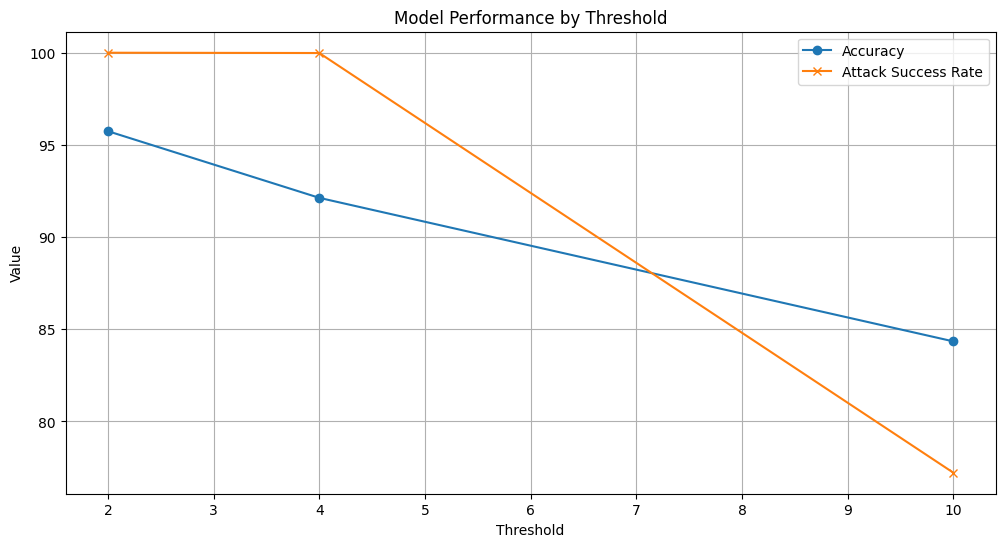

In [99]:
import matplotlib.pyplot as plt

thresholds = list(results.keys())
accuracies = [metrics['accuracy'] for metrics in results.values()]
attack_success_rates = [metrics['attack_success_rate'] for metrics in results.values()]

plt.figure(figsize=(12, 6))

plt.plot(thresholds, accuracies, label='Accuracy', marker='o')
plt.plot(thresholds, attack_success_rates, label='Attack Success Rate', marker='x')

plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Model Performance by Threshold')
plt.legend()
plt.grid(True)

plt.show()